In [1]:
import pandas as pd
data = pd.read_csv("data/final_data.csv")

In [2]:
data = data[data.file!='file']
data

,Unnamed: 0,file,_refln_index_h,_refln_index_k,_refln_index_l,phase_bool,I_calc,_refln_F_squared_meas
0,0,/data/xr-ml/hkls/aa2004.hkl,-10,-10,1,1,0.041705,0.0
1,1,/data/xr-ml/hkls/aa2004.hkl,-10,-10,2,1,0.011429,0.0
2,2,/data/xr-ml/hkls/aa2004.hkl,-10,-10,3,1,0.000520,0.0
3,3,/data/xr-ml/hkls/aa2004.hkl,-10,-10,4,1,0.003150,0.0
4,4,/data/xr-ml/hkls/aa2004.hkl,-10,-10,5,1,0.000071,0.0
...,...,...,...,...,...,...,...,...
34928715,35299115,/data/xr-ml/hkls/zs2327.hkl,10,10,6,1,0.000503,0.0
34928716,35299116,/data/xr-ml/hkls/zs2327.hkl,10,10,7,1,0.000037,0.0
34928717,35299117,/data/xr-ml/hkls/zs2327.hkl,10,10,8,0,0.000537,0.0
34928718,35299118,/data/xr-ml/hkls/zs2327.hkl,10,10,9,1,0.000047,0.0


In [3]:
new_data = pd.DataFrame()
new_data['file'] = data['file']
new_data['h'] = data['_refln_index_h'].astype(float).astype(int)
new_data['k'] = data['_refln_index_k'].astype(float).astype(int)
new_data['l'] = data['_refln_index_l'].astype(float).astype(int)
new_data['I'] = data._refln_F_squared_meas.astype(float)
new_data['phase'] = data.phase_bool.astype(float).astype(int)
data = new_data

In [4]:
data

,file,h,k,l,I,phase
0,/data/xr-ml/hkls/aa2004.hkl,-10,-10,1,0.0,1
1,/data/xr-ml/hkls/aa2004.hkl,-10,-10,2,0.0,1
2,/data/xr-ml/hkls/aa2004.hkl,-10,-10,3,0.0,1
3,/data/xr-ml/hkls/aa2004.hkl,-10,-10,4,0.0,1
4,/data/xr-ml/hkls/aa2004.hkl,-10,-10,5,0.0,1
...,...,...,...,...,...,...
34928715,/data/xr-ml/hkls/zs2327.hkl,10,10,6,0.0,1
34928716,/data/xr-ml/hkls/zs2327.hkl,10,10,7,0.0,1
34928717,/data/xr-ml/hkls/zs2327.hkl,10,10,8,0.0,0
34928718,/data/xr-ml/hkls/zs2327.hkl,10,10,9,0.0,1


In [5]:
data = data.groupby(['file','h', 'k', 'l']).mean().reset_index()
data = data.sample(frac=1).reset_index(drop=True)
data['R'] = data.h*data.h + data.k*data.k + data.l*data.l
#data = data[data.R<50]
data['phase'] = data.phase.astype(float).astype(int)

In [6]:
data.groupby('phase').agg('count')

,file,h,k,l,I,R
phase,,,,,,
0,17769206,17769206,17769206,17769206,17769206,17769206
1,17159514,17159514,17159514,17159514,17159514,17159514


In [7]:
len(data.file.unique())

7544

Посмотрим на соотношение нулей и единиц в файлах

IntProgress(value=0)

0.41555075593952484 1.0


Text(0, 0.5, 'N_files')

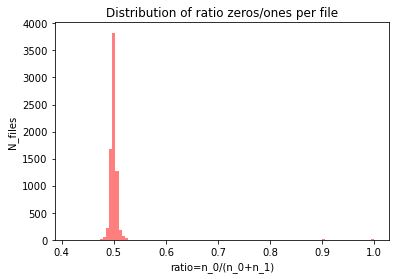

In [8]:
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt

grouped = data.groupby('file')
groups = [df for name,df in grouped]
arr = []
i=0

progress = IntProgress(min=0)
display(progress)
for file_df in groups:
    i+=1
    n_0 = file_df[file_df.phase==0].h.size
    n_1 = file_df[file_df.phase==1].h.size
    #print(i, n_0, n_1,rat)
    #TODO add params
    rat = n_0/(n_1+n_0)
    arr.append(rat)
    progress.value=i
arr = np.array(arr)
print(arr.min(), arr.max())
plt.hist(arr, alpha=0.5, bins=100, color='red')
plt.title('Distribution of ratio zeros/ones per file')
plt.xlabel('ratio=n_0/(n_0+n_1)')
plt.ylabel('N_files')

# Создаем X и Y для обучения

Для обучения требуются два массива, X:float - (N,4630) и Y:int - (N, 4630). Создаем их:

In [9]:
from ipywidgets import IntProgress
from IPython.display import display

x_arr = []
y_arr = []

progress = IntProgress(min=0, max=len(groups))
display(progress)

i=0
for df in groups:
    i+=1
    progress.value=i
    if len(df.h)!=4630: continue
    df.I = df.I.astype(float)/df.I.astype(float).max()
    sorted = df.sort_values(by=['R', 'h', 'k', 'l'])
    x_arr.append(np.array(sorted.I))
    y_arr.append(np.array(sorted.phase))

IntProgress(value=0, max=7544)

In [10]:
del(data)
del(grouped)

Посмотрим на то что получилось

In [11]:
from keras.utils import to_categorical
x_arr = np.array(x_arr, dtype=float)
y_arr = np.array(y_arr, dtype=float)
print(f"""
X: {x_arr.shape}
Y: {y_arr.shape}
""")


X: (7544, 4630)
Y: (7544, 4630)



In [12]:
y_arr = to_categorical(y_arr)[:,:709]

In [13]:
print(f"""
X: {x_arr.shape}
Y: {y_arr.shape}
""")


X: (7544, 4630)
Y: (7544, 709, 2)



# Создаем модель

In [14]:
import keras
model = keras.models.load_model('models/favourite_wife/')

In [15]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_22 (Batc (None, 4630)              18520     
_________________________________________________________________
dense_24 (Dense)             (None, 300)               1389300   
_________________________________________________________________
batch_normalization_23 (Batc (None, 300)               1200      
_________________________________________________________________
dense_25 (Dense)             (None, 1418)              426818    
_________________________________________________________________
reshape_3 (Reshape)          (None, 709, None)         0         
_________________________________________________________________
softmax_10 (Softmax)         (None, 709, None)         0         
Total params: 1,835,838
Trainable params: 1,825,978
Non-trainable params: 9,860
_______________________________________

In [24]:
model.fit(x_arr[:3500], y_arr[:3500], epochs=5)

Epoch 1/5
110/110 [==============================] - 4s 34ms/step - loss: 0.6875 - categorical_accuracy: 0.5337
Epoch 2/5
110/110 [==============================] - 4s 40ms/step - loss: 0.6860 - categorical_accuracy: 0.5401
Epoch 3/5
110/110 [==============================] - 5s 42ms/step - loss: 0.6842 - categorical_accuracy: 0.5461
Epoch 4/5
110/110 [==============================] - 5s 41ms/step - loss: 0.6822 - categorical_accuracy: 0.5524
Epoch 5/5
110/110 [==============================] - 5s 46ms/step - loss: 0.6801 - categorical_accuracy: 0.5578


In [25]:
model.evaluate(x_arr[3500:], y_arr[3500:])

127/127 [==============================] - 2s 18ms/step - loss: 0.7001 - categorical_accuracy: 0.5122


[0.7000636458396912, 0.5121990442276001]